In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import torch
from util import *

In [2]:
class CFG:
    seed = 17
    type_num = 4
    selected_cols = ['motor_vibe', 'motor_current', 'motor_rpm']

In [3]:
seed_everything(CFG.seed)

c:\Users\Root\dacon\AiSparkChallenge4th-3\.conda\lib\site-packages\torch\random.py:46: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  return default_generator.manual_seed(seed)


In [4]:
train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

In [5]:
train_type = train['type']
test_type = test['type']
train.drop(['type'], axis=1, inplace=True)
test.drop(['type'], axis=1, inplace=True)

In [6]:
train['out_pressure'].value_counts()

0.7    2463
Name: out_pressure, dtype: int64

In [7]:
train = train[CFG.selected_cols]
test = test[CFG.selected_cols]

<Axes: >

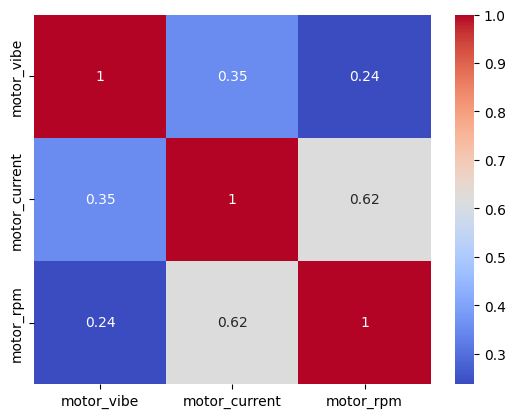

In [8]:
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

In [9]:
train['type'] = train_type.apply(lambda x: x if x<4 else 0)
test['type'] = test_type.apply(lambda x: x if x<4 else 0)

In [10]:
data_ct, type_ct = build_container(train, test, type_num=CFG.type_num)

C:\Users\Root\AppData\Local\Temp\ipykernel_16356\2352029475.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=test_df, x='0', y='1', palette='bright')
C:\Users\Root\AppData\Local\Temp\ipykernel_16356\2352029475.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=train_df, x='0', y='1', palette='bright')
C:\Users\Root\AppData\Local\Temp\ipykernel_16356\2352029475.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=test_df, x='0', y='1', palette='bright')
C:\Users\Root\AppData\Local\Temp\ipykernel_16356\2352029475.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=train_df, x='0', y='1', palette='bright')
C:\Users\Root\AppData\Local\Temp\ipykernel_16356\2352029475.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = 

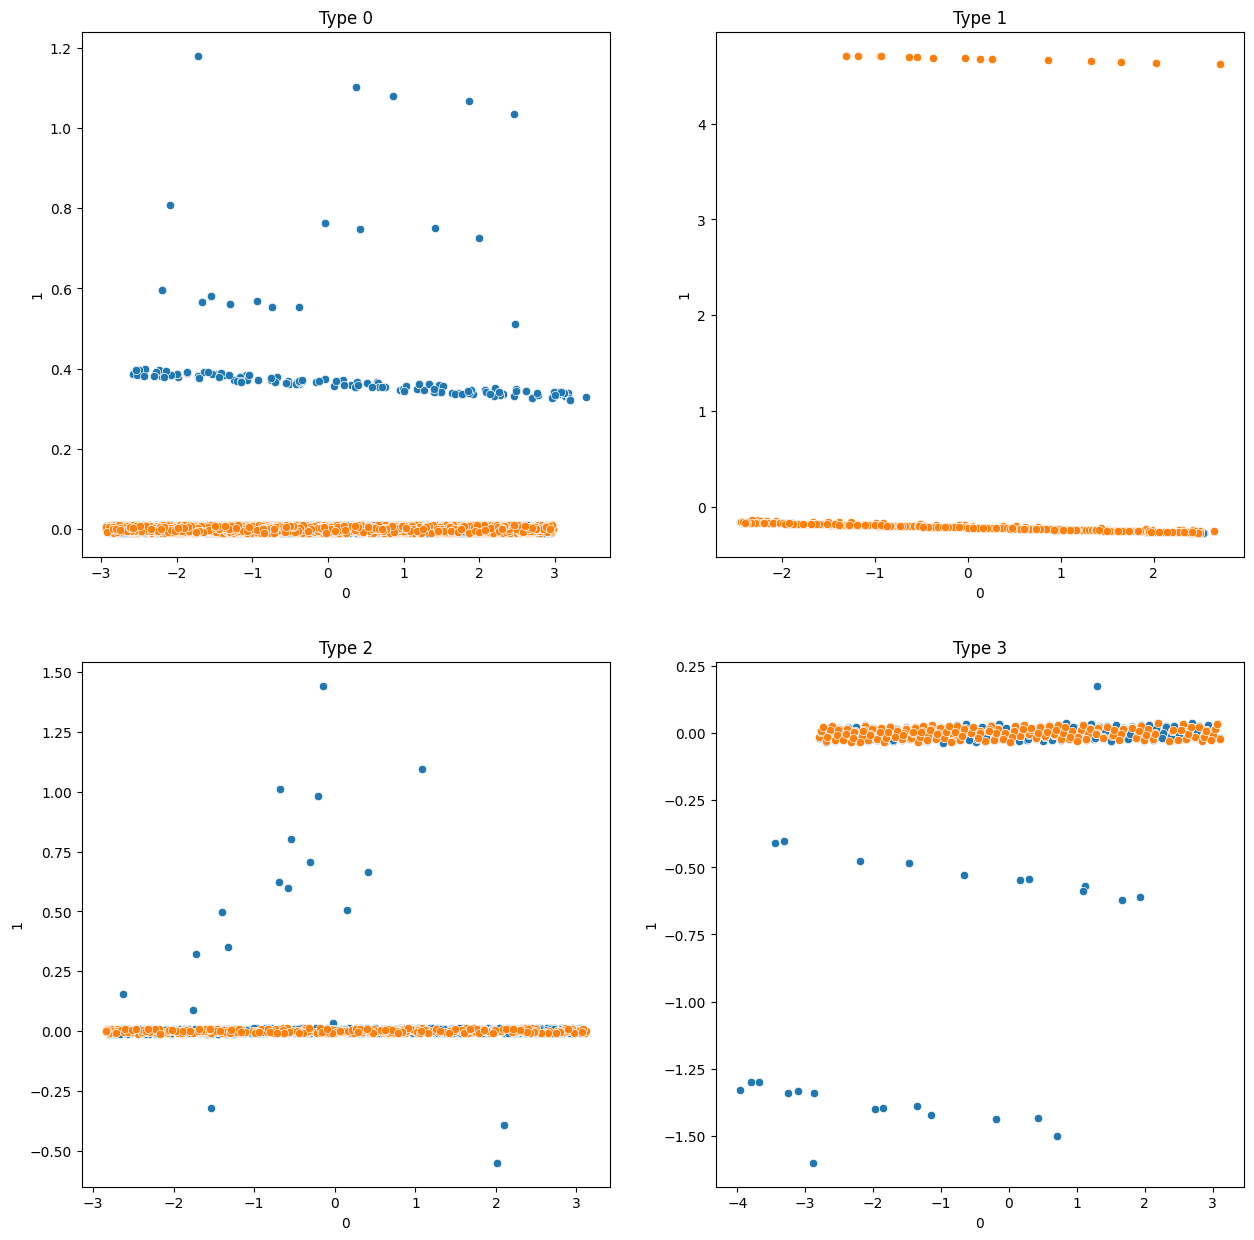

In [11]:
fig = plt.figure(figsize=(15,15))
data_ppc = []
for i, (train, test) in enumerate(data_ct):
    train_df, test_df = pca(*scaler(train, test))
    data_ppc.append((train_df, test_df))
    ax = plt.subplot(2, 2, i+1)
    ax.set_title(f"Type {i}")
    ax = sns.scatterplot(data=test_df, x='0', y='1', palette='bright')
    ax = sns.scatterplot(data=train_df, x='0', y='1', palette='bright')

In [12]:
rmv = data_ppc[1][0][data_ppc[1][0]['1']>4].index
data_ppc[1][0].drop(rmv, inplace=True)
type_ct[1][0].drop(rmv, inplace=True)

In [13]:
# np.save("../outliers.npy", rmv.to_numpy())

In [14]:
test_concat = []
for i, (train_df, test_df) in enumerate(data_ppc):
    is_anomaly = ols_detect_anomaly(train_df, test_df, by='whisker')
    test_concat.append(test_df.copy().assign(anomaly=is_anomaly))

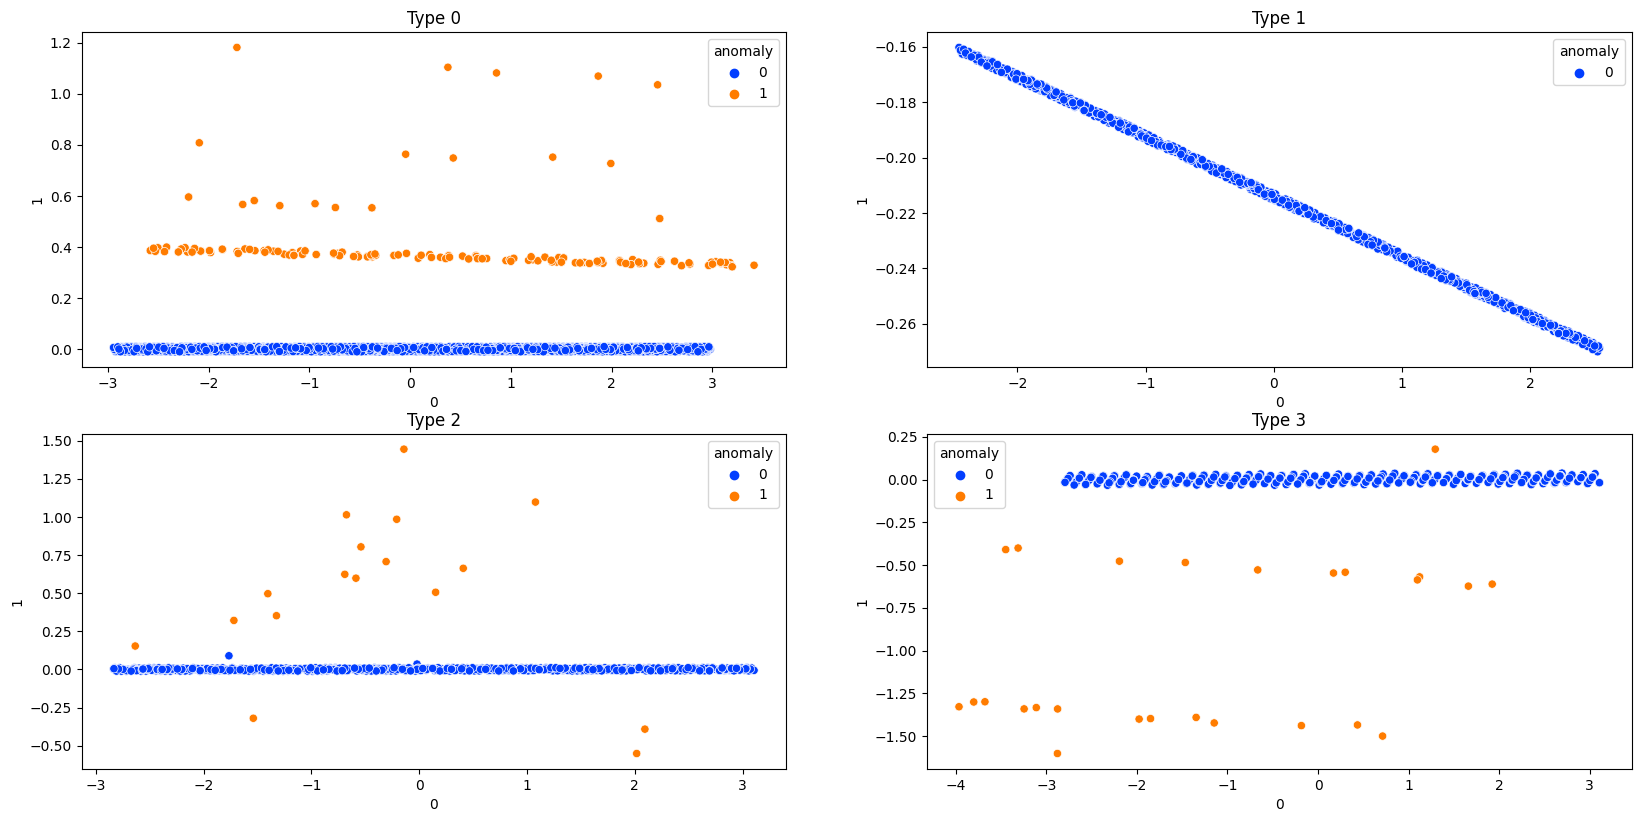

In [15]:
fig = plt.figure(figsize=(20,20))
for i, test_data in enumerate(test_concat):
    ax = plt.subplot(4,2,i+1)
    ax.set_title(f"Type {i}")
    sns.scatterplot(data=test_data, x='0', y='1', hue='anomaly', palette='bright')

In [16]:
anomaly_sub = pd.concat(test_concat).sort_index()['anomaly']

In [17]:
anomaly_sub.value_counts()

0    7068
1     321
Name: anomaly, dtype: int64

In [18]:
sub = pd.read_csv("../data/answer_sample.csv")
sub['label'] = anomaly_sub

In [19]:
sub.to_csv("../results/ols_submission_4.csv", index=False)

from sklearn.neighbors import LocalOutlierFactor

anomaly_container = []
for train_df, test_df in df_container:
    clf = LocalOutlierFactor(n_neighbors=100, novelty=True)
    clf.fit(train_df)
    result = pd.DataFrame(clf.predict(test_df))
    result.replace(to_replace=1, value=0, inplace=True)
    result.replace(to_replace=-1, value=1, inplace=True)
    anomaly_container.append(result)

result = pd.concat(anomaly_container).reset_index(drop=True)

test_pca['anomaly'] = result
fig = plt.figure(figsize=(20,20))
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    ax.set_title(f"Type {i}")
    sns.scatterplot(data=test_pca[test_pca.type==i], x='0', y='1', hue='anomaly', palette='bright')

**One Class SVM**

from sklearn.svm import OneClassSVM

anomaly_container = []
for train_df, test_df in df_container:
    clf = OneClassSVM(kernel='linear', gamma='auto', verbose=True).fit(train_df)
    result = pd.DataFrame(clf.predict(test_df))
    result.replace(to_replace=1, value=0, inplace=True)
    result.replace(to_replace=-1, value=1, inplace=True)
    anomaly_container.append(result)

result = pd.concat(anomaly_container).reset_index(drop=True)

test_pca['anomaly'] = result
fig = plt.figure(figsize=(20,20))
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    ax.set_title(f"Type {i}")
    sns.scatterplot(data=test_pca[test_pca.type==i], x='0', y='1', hue='anomaly', palette='bright')

result = clf.predict(test)
result = pd.DataFrame(result)
result.replace(to_replace=1, value=0, inplace=True)
result.replace(to_replace=-1, value=1, inplace=True)